In [8]:
import pandas as pd
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

<Axes: xlabel='id'>

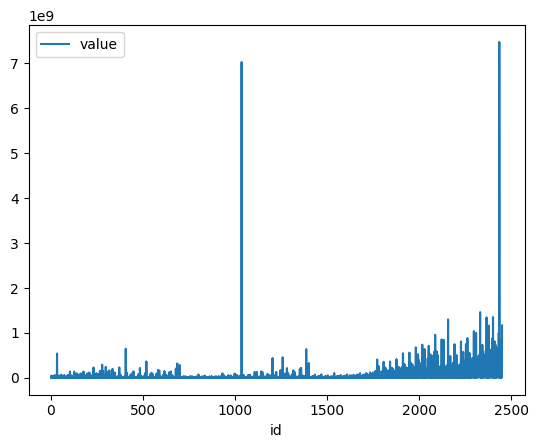

In [17]:
df = pd.read_csv("D:\\myscripts\\data\\single.csv", index_col=[0])
df.plot(kind='line')

In [13]:
df.count()
df.head()

#maxval = df.loc[df.idxmax()]
df.describe

value    2449
dtype: int64

,value
id,
1,755858
2,51483437
3,825115
4,3722850
5,2327135


<bound method NDFrame.describe of            value
id              
1         755858
2       51483437
3         825115
4        3722850
5        2327135
...          ...
2445   660311804
2446     5666102
2447   577591772
2448    47135685
2449  1168242161

[2449 rows x 1 columns]>

<Axes: xlabel='id'>

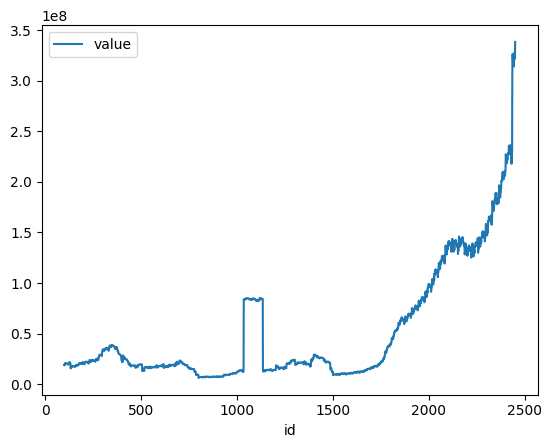

In [22]:
df.rolling(window=100).mean().plot()

In [193]:
model = SimpleExpSmoothing(df_new)
fit1 = model.fit()
pred1 = fit1.forecast(10).rename(r'$\alpha=%s$'%fit1.model.params['smoothing_level'])

c:\users\edwinvivekn\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\edwinvivekn\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
c:\users\edwinvivekn\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


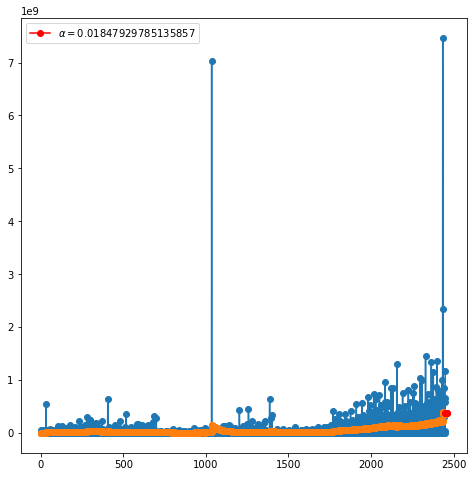

In [174]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(df_new.index, df_new, marker='o')
ax.plot(df_new.index, fit1.fittedvalues, marker ='o')
line1, = plt.plot(pred1, marker='o', color='red')
plt.legend([line1], [pred1.name]) 

In [58]:
(fit1.params['smoothing_level'])

0.01847929785135857

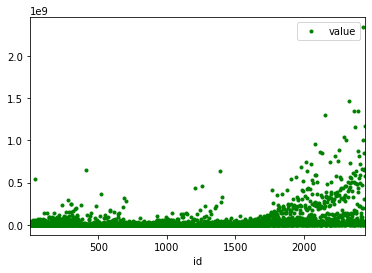

In [269]:
df1 = df.drop(df_new.idxmax())
df1.drop(df1.idxmax(), inplace=True)
df1.plot(style='g.')

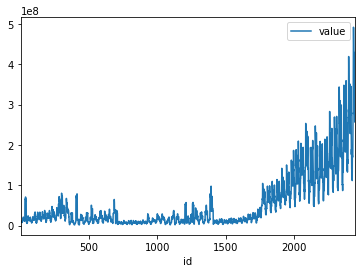

In [270]:
#stationarity check - rolling statistics
df1.rolling(window=10).mean().plot()

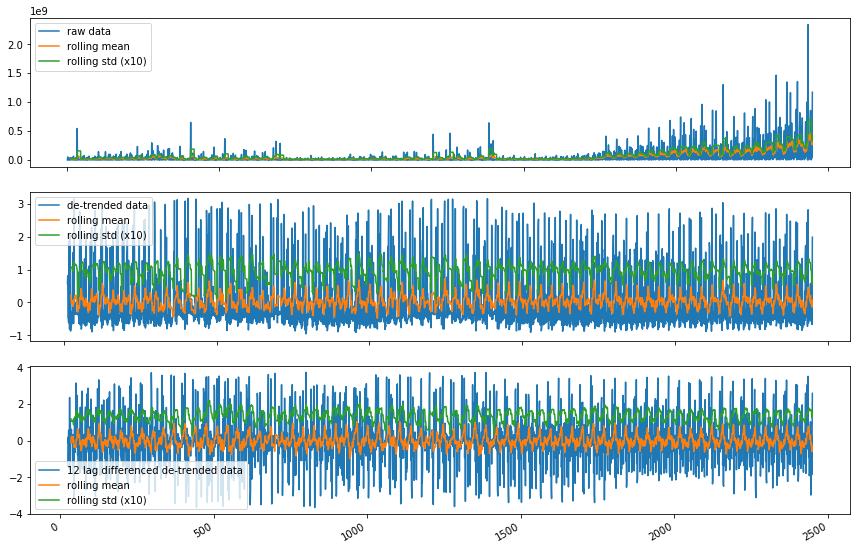

In [271]:
df1['z_data'] = (df1['value'] - df1.value.rolling(window=12).mean()) / df1.value.rolling(window=12).std()
df1['zp_data'] = df1['z_data'] - df1['z_data'].shift(12)

def plot_rolling(df):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    ax[0].plot(df.index, df.value, label='raw data')
    ax[0].plot(df.value.rolling(window=12).mean(), label="rolling mean");
    ax[0].plot(df.value.rolling(window=12).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df.index, df.z_data, label="de-trended data")
    ax[1].plot(df.z_data.rolling(window=12).mean(), label="rolling mean");
    ax[1].plot(df.z_data.rolling(window=12).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(df.index, df.zp_data, label="12 lag differenced de-trended data")
    ax[2].plot(df.zp_data.rolling(window=12).mean(), label="rolling mean");
    ax[2].plot(df.zp_data.rolling(window=12).std(), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()
    


plot_rolling(df1)

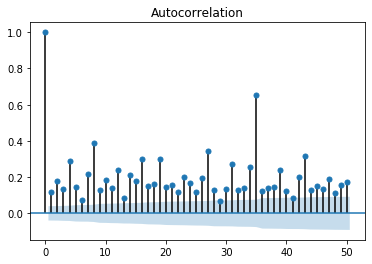

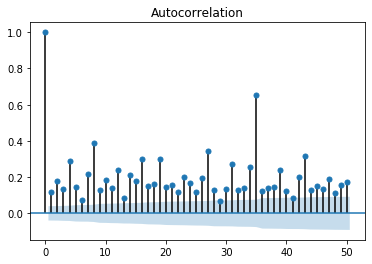

In [273]:
#stationarity check - autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df1.value, lags=50)

c:\users\edwinvivekn\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


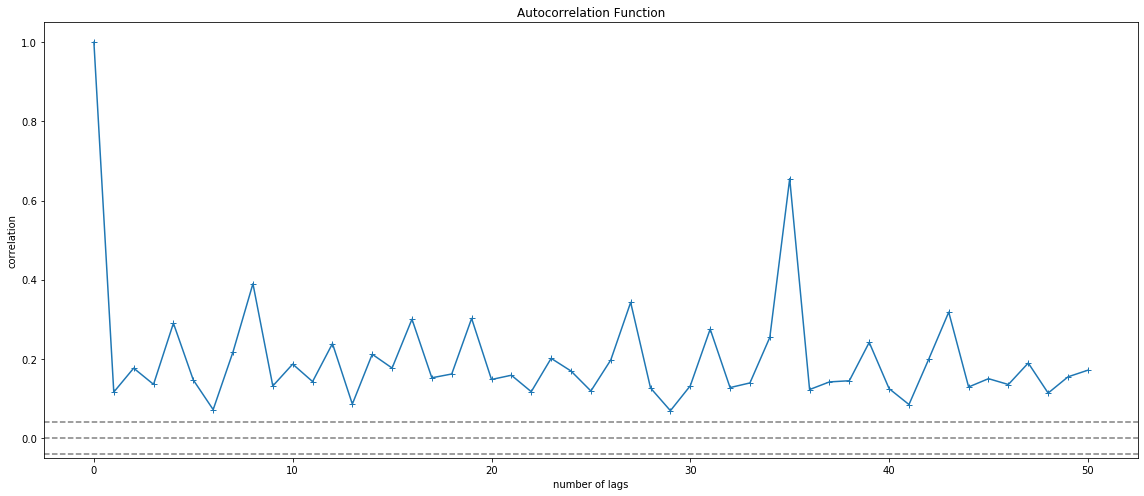

In [274]:
#ACF - alternate to above
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(df1.value, nlags=50)
#Plot ACF:
plt.figure(figsize=(16, 7))
plt.plot(lag_acf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df1)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df1)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.tight_layout()

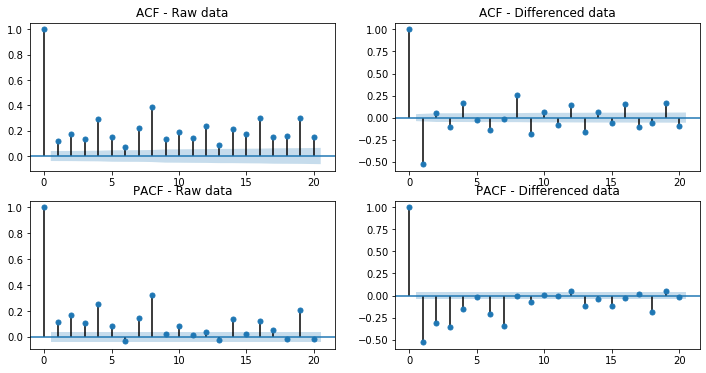

In [275]:
#differencing
first_diff = (df1.value- (df1.value).shift()).dropna()

fig, ax = plt.subplots(2, 2, figsize=(12,6))
ax[0, 0] = plot_acf(df1.value, ax=ax[0, 0], lags=20, title="ACF - Raw data")
ax[1, 0] = plot_pacf(df1.value, ax=ax[1, 0], lags=20, title="PACF - Raw data")
ax[0, 1] = plot_acf(first_diff , ax=ax[0, 1], lags=20, title="ACF - Differenced data")
ax[1, 1] = plot_pacf(first_diff, ax=ax[1, 1], lags=20, title="PACF - Differenced data")


In [276]:
#ARIMA (0,0,0) vs (0,1,0)
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df1.value.dropna(), (0, 0, 0))
res_000 = model.fit()
print(res_000.summary())

                              ARMA Model Results                              
Dep. Variable:                  value   No. Observations:                 2447
Model:                     ARMA(0, 0)   Log Likelihood              -49392.622
Method:                           css   S.D. of innovations      141248523.692
Date:                Sat, 13 Feb 2021   AIC                          98789.243
Time:                        23:58:31   BIC                          98800.848
Sample:                             0   HQIC                         98793.461
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.272e+07   2.86e+06     18.465      0.000    4.71e+07    5.83e+07


c:\users\edwinvivekn\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [277]:
model1 = ARIMA(df1.value.dropna(), (0, 1, 0))
res_010 = model1.fit()
print(res_010.summary())


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                 2446
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -50052.081
Method:                           css   S.D. of innovations      186490544.333
Date:                Sat, 13 Feb 2021   AIC                         100108.163
Time:                        23:58:33   BIC                         100119.767
Sample:                             1   HQIC                        100112.380
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.773e+05   3.77e+06      0.127      0.899   -6.91e+06    7.87e+06


c:\users\edwinvivekn\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\edwinvivekn\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

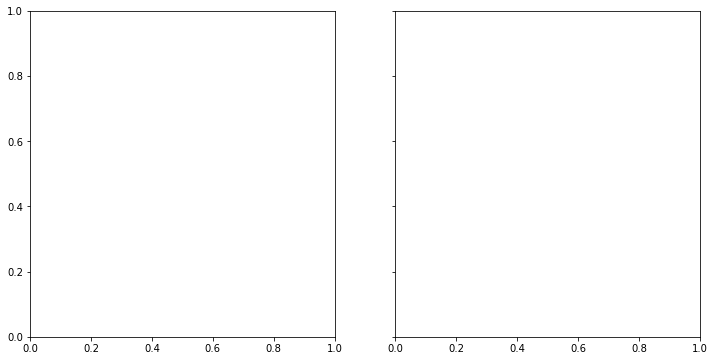

In [278]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=350, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend();

ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=350, color='r');
ax[1].set_title("ARIMA(0,1,0)");
ax[1].legend();

In [ ]:
#choosing AR and MA



In [ ]:
#plotting forecast


pandas.core.frame.DataFrame